<a href="https://www.kaggle.com/code/subhajeetdas/weather-forecasting-of-kolkata?scriptVersionId=133149518" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Import Libraries

<p style="font-family:arial; font-weight:bold; letter-spacing: 2px; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid red">

In [1]:
!pip install calplot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - \ done
  Created wheel for calplot: filename=calplot-0.1.7.5-py3-none-any.whl size=8121 sha256=9cf108ed0b97ad7ba51ac43cf899ac8f804d0fb2381d139cc995234c68e8cad0
  Stored in directory: /root/.cache/pip/wheels/77/75/32/a518a4a1421776a93e1ede33cb8dac474095bf31fed7e4e22c
Successfully built calplot


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import calplot
from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_plotly, plot_components_plotly, plot_cross_validation_metric
from prophet.serialize import model_to_json, model_from_json

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
import warnings
warnings.filterwarnings('ignore')

/kaggle/input/daily-temperature-of-major-cities/city_temperature.csv


# Load Data

<p style="font-family:arial; font-weight:bold; letter-spacing: 2px; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid red">

In [3]:
df = pd.read_csv("/kaggle/input/daily-temperature-of-major-cities/city_temperature.csv")
df

Region  Country                   State                  City  \
0               Africa  Algeria                     NaN               Algiers   
1               Africa  Algeria                     NaN               Algiers   
2               Africa  Algeria                     NaN               Algiers   
3               Africa  Algeria                     NaN               Algiers   
4               Africa  Algeria                     NaN               Algiers   
...                ...      ...                     ...                   ...   
2906322  North America       US  Additional Territories  San Juan Puerto Rico   
2906323  North America       US  Additional Territories  San Juan Puerto Rico   
2906324  North America       US  Additional Territories  San Juan Puerto Rico   
2906325  North America       US  Additional Territories  San Juan Puerto Rico   
2906326  North America       US  Additional Territories  San Juan Puerto Rico   

         Month  Day  Year  AvgTemperature  
0            1    1  1995            64.2  
1            1    2  1995            49.4  
2            1    3  1995            48.8  
3            1    4  1995            46.4  
4            1    5  1995            47.9  
...        ...  ...   ...             ...  
2906322      7   27  2013            82.4  
2906323      7   28  2013            81.6  
2906324      7   29  2013            84.2  
2906325      7   30  2013            83.8  
2906326      7   31  2013            83.6  

[2906327 rows x 8 columns]

# Data Cleaning & Visualization

<p style="font-family:arial; font-weight:bold; letter-spacing: 2px; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid red">

In [4]:
df = df[df["Country"] == "India"]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37063 entries, 312523 to 349585
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Region          37063 non-null  object 
 1   Country         37063 non-null  object 
 2   State           0 non-null      object 
 3   City            37063 non-null  object 
 4   Month           37063 non-null  int64  
 5   Day             37063 non-null  int64  
 6   Year            37063 non-null  int64  
 7   AvgTemperature  37063 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 2.5+ MB


In [6]:
df.size

296504

In [7]:
df.isnull().sum()

Region                0
Country               0
State             37063
City                  0
Month                 0
Day                   0
Year                  0
AvgTemperature        0
dtype: int64

<Axes: >

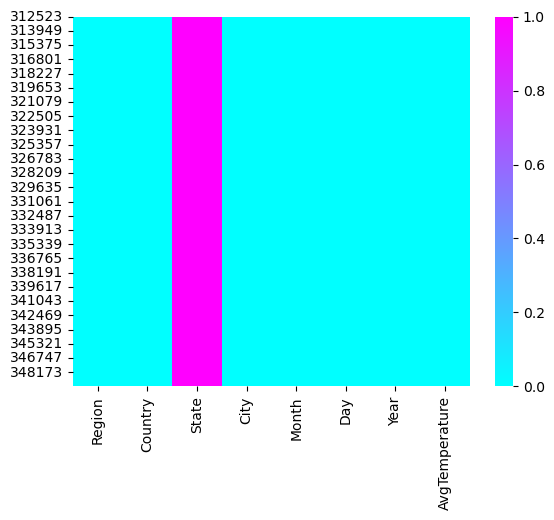

In [8]:
sns.heatmap(df.isnull(), cmap = "cool")

In [9]:
df.drop("State", axis = 1, inplace = True)

In [10]:
df.City.unique()

array(['Bombay (Mumbai)', 'Calcutta', 'Chennai (Madras)', 'Delhi'],
      dtype=object)

In [11]:
df = df[df["City"] == "Calcutta"]
df

Region Country      City  Month  Day  Year  AvgTemperature
321789   Asia   India  Calcutta      1    1  1995            63.0
321790   Asia   India  Calcutta      1    2  1995            61.4
321791   Asia   India  Calcutta      1    3  1995            60.6
321792   Asia   India  Calcutta      1    4  1995            61.3
321793   Asia   India  Calcutta      1    5  1995            62.3
...       ...     ...       ...    ...  ...   ...             ...
331050   Asia   India  Calcutta      5    9  2020            88.9
331051   Asia   India  Calcutta      5   10  2020            84.5
331052   Asia   India  Calcutta      5   11  2020            84.6
331053   Asia   India  Calcutta      5   12  2020            88.7
331054   Asia   India  Calcutta      5   13  2020            85.6

[9266 rows x 7 columns]

In [12]:
df.describe().T

count         mean        std     min     25%     50%  \
Month           9266.0     6.468919   3.457327     1.0     3.0     6.0   
Day             9266.0    15.717354   8.801516     1.0     8.0    16.0   
Year            9266.0  2007.188215   7.325356  1995.0  2001.0  2007.0   
AvgTemperature  9266.0    78.871811  14.288654   -99.0    73.9    82.3   

                   75%     max  
Month              9.0    12.0  
Day               23.0    31.0  
Year            2014.0  2020.0  
AvgTemperature    85.5    96.8

In [13]:
df["datetime"] = df.apply(lambda x : datetime.datetime(x["Year"], x["Month"], x["Day"], 0, 0, 0, 0), axis=1)
df.index = df["datetime"].values
df

Region Country      City  Month  Day  Year  AvgTemperature  \
1995-01-01   Asia   India  Calcutta      1    1  1995            63.0   
1995-01-02   Asia   India  Calcutta      1    2  1995            61.4   
1995-01-03   Asia   India  Calcutta      1    3  1995            60.6   
1995-01-04   Asia   India  Calcutta      1    4  1995            61.3   
1995-01-05   Asia   India  Calcutta      1    5  1995            62.3   
...           ...     ...       ...    ...  ...   ...             ...   
2020-05-09   Asia   India  Calcutta      5    9  2020            88.9   
2020-05-10   Asia   India  Calcutta      5   10  2020            84.5   
2020-05-11   Asia   India  Calcutta      5   11  2020            84.6   
2020-05-12   Asia   India  Calcutta      5   12  2020            88.7   
2020-05-13   Asia   India  Calcutta      5   13  2020            85.6   

             datetime  
1995-01-01 1995-01-01  
1995-01-02 1995-01-02  
1995-01-03 1995-01-03  
1995-01-04 1995-01-04  
1995-01-05 1995-01-05  
...               ...  
2020-05-09 2020-05-09  
2020-05-10 2020-05-10  
2020-05-11 2020-05-11  
2020-05-12 2020-05-12  
2020-05-13 2020-05-13  

[9266 rows x 8 columns]

In [14]:
df = df[df["AvgTemperature"] != -99]
df["TempInC"] = df["AvgTemperature"].apply(lambda x : (x-32)/1.8)
df

Region Country      City  Month  Day  Year  AvgTemperature  \
1995-01-01   Asia   India  Calcutta      1    1  1995            63.0   
1995-01-02   Asia   India  Calcutta      1    2  1995            61.4   
1995-01-03   Asia   India  Calcutta      1    3  1995            60.6   
1995-01-04   Asia   India  Calcutta      1    4  1995            61.3   
1995-01-05   Asia   India  Calcutta      1    5  1995            62.3   
...           ...     ...       ...    ...  ...   ...             ...   
2020-05-09   Asia   India  Calcutta      5    9  2020            88.9   
2020-05-10   Asia   India  Calcutta      5   10  2020            84.5   
2020-05-11   Asia   India  Calcutta      5   11  2020            84.6   
2020-05-12   Asia   India  Calcutta      5   12  2020            88.7   
2020-05-13   Asia   India  Calcutta      5   13  2020            85.6   

             datetime    TempInC  
1995-01-01 1995-01-01  17.222222  
1995-01-02 1995-01-02  16.333333  
1995-01-03 1995-01-03  15.888889  
1995-01-04 1995-01-04  16.277778  
1995-01-05 1995-01-05  16.833333  
...               ...        ...  
2020-05-09 2020-05-09  31.611111  
2020-05-10 2020-05-10  29.166667  
2020-05-11 2020-05-11  29.222222  
2020-05-12 2020-05-12  31.500000  
2020-05-13 2020-05-13  29.777778  

[9225 rows x 9 columns]

In [15]:
df.dtypes

Region                    object
Country                   object
City                      object
Month                      int64
Day                        int64
Year                       int64
AvgTemperature           float64
datetime          datetime64[ns]
TempInC                  float64
dtype: object

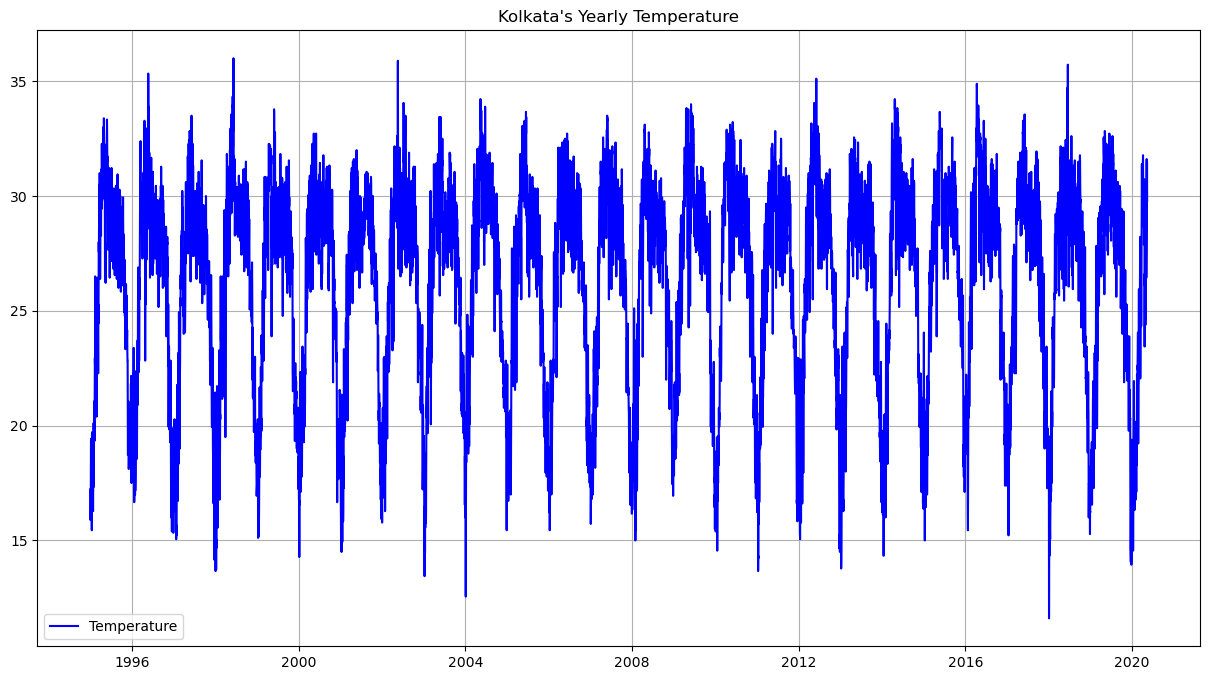

In [16]:
plt.figure(figsize=(15, 8))
plt.title("Kolkata's Yearly Temperature")
plt.plot(df['datetime'], df['TempInC'], color = 'blue', linewidth = 1.5, label = "Temperature")
plt.grid()
plt.legend(loc ="lower left")

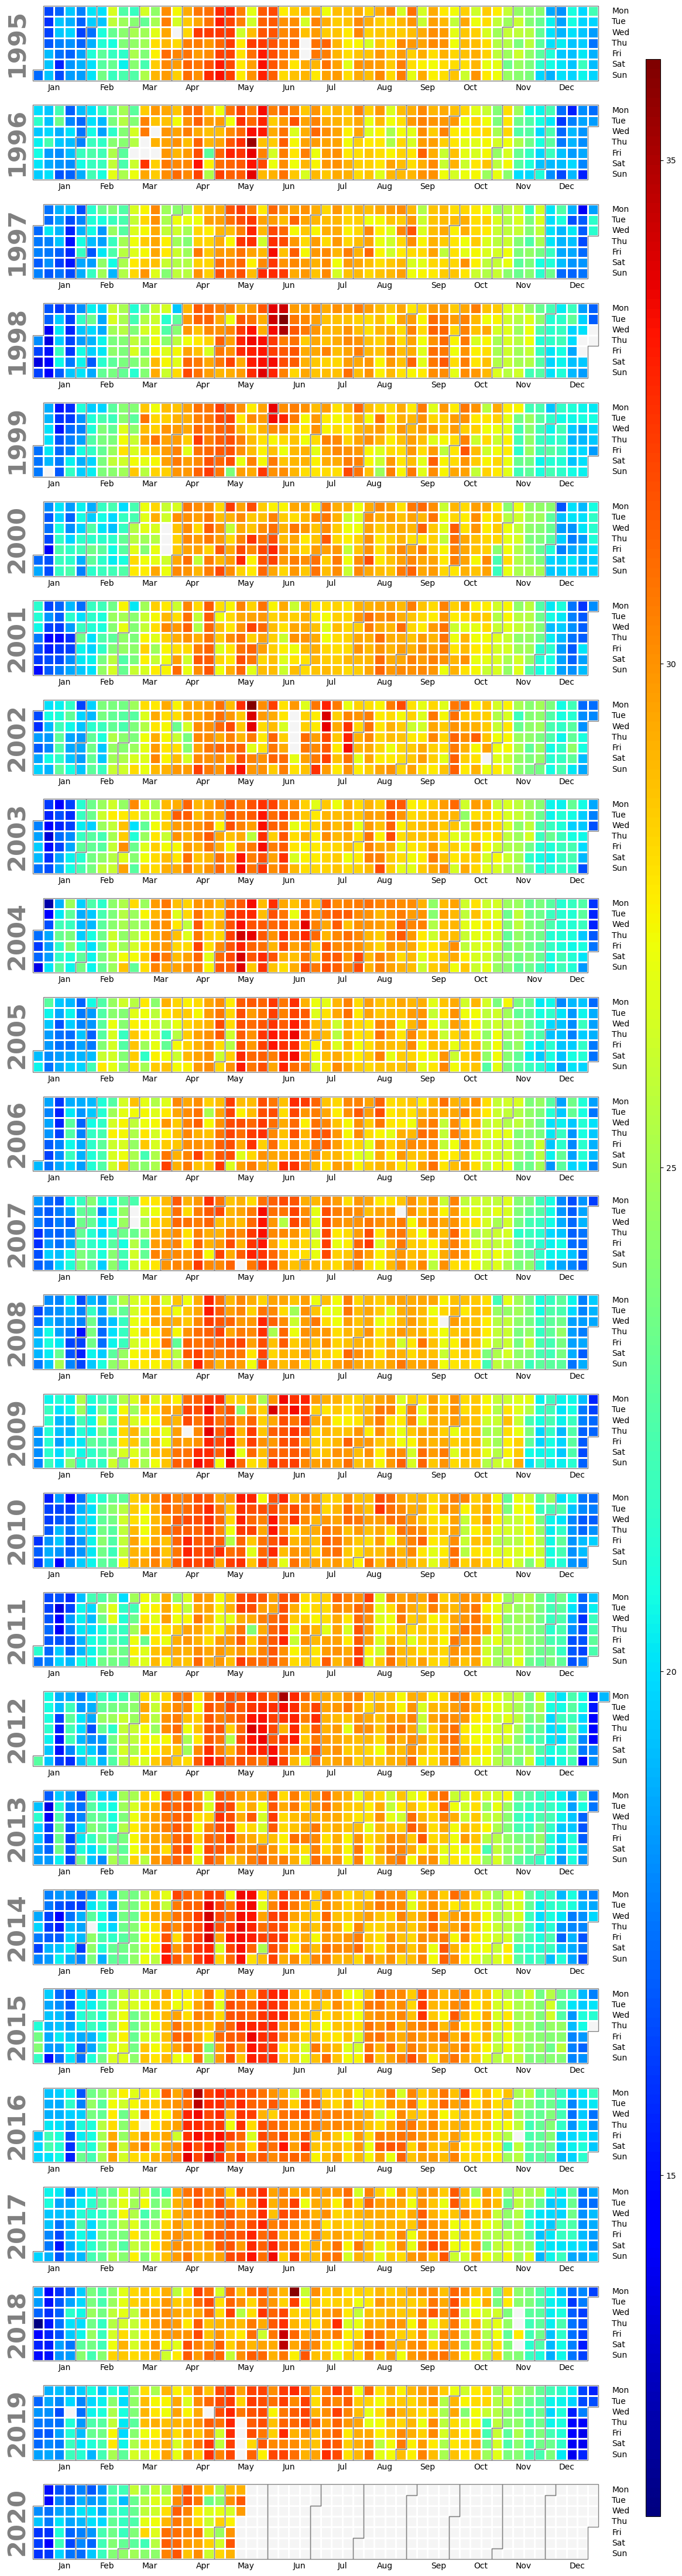

In [17]:
fig = calplot.calplot(df["TempInC"], how = "mean", cmap='jet')

## Making a New Dataframe with Date & Temperature in Celsius Only for the Prophet Model

<p style="font-family:arial; font-weight:bold; letter-spacing: 2px; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid red">

In [18]:
n_df = df[['datetime', 'TempInC']]
n_df

datetime    TempInC
1995-01-01 1995-01-01  17.222222
1995-01-02 1995-01-02  16.333333
1995-01-03 1995-01-03  15.888889
1995-01-04 1995-01-04  16.277778
1995-01-05 1995-01-05  16.833333
...               ...        ...
2020-05-09 2020-05-09  31.611111
2020-05-10 2020-05-10  29.166667
2020-05-11 2020-05-11  29.222222
2020-05-12 2020-05-12  31.500000
2020-05-13 2020-05-13  29.777778

[9225 rows x 2 columns]

In [19]:
n_df.rename(columns = {'datetime' :'ds', 'TempInC' : 'y'}, inplace = True)

# Prophet Model

<p style="font-family:arial; font-weight:bold; letter-spacing: 2px; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid blue">

In [20]:
model = Prophet()
model.fit(n_df)

09:20:53 - cmdstanpy - INFO - Chain [1] start processing
09:20:55 - cmdstanpy - INFO - Chain [1] done processing


In [21]:
df_future = model.make_future_dataframe(periods = 850)
forecast = model.predict(df_future)

In [22]:
forecast

ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0     1995-01-01  26.332092   15.765974   20.212827    26.332092    26.332092   
1     1995-01-02  26.331858   15.796068   19.949094    26.331858    26.331858   
2     1995-01-03  26.331624   15.771082   20.012919    26.331624    26.331624   
3     1995-01-04  26.331390   15.804374   19.950920    26.331390    26.331390   
4     1995-01-05  26.331156   15.646627   19.827502    26.331156    26.331156   
...          ...        ...         ...         ...          ...          ...   
10070 2022-09-06  25.339353   25.702608   29.950629    25.024232    25.661004   
10071 2022-09-07  25.338693   25.534913   29.859614    25.022886    25.660885   
10072 2022-09-08  25.338032   25.513220   29.739926    25.021540    25.660765   
10073 2022-09-09  25.337372   25.607854   29.959339    25.020194    25.660646   
10074 2022-09-10  25.336711   25.619702   29.825708    25.018847    25.660526   

       additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0           -8.353965             -8.353965             -8.353965  0.009682   
1           -8.414988             -8.414988             -8.414988 -0.003884   
2           -8.417886             -8.417886             -8.417886  0.033276   
3           -8.480953             -8.480953             -8.480953  0.002686   
4           -8.544887             -8.544887             -8.544887 -0.036510   
...               ...                   ...                   ...       ...   
10070        2.466042              2.466042              2.466042  0.033276   
10071        2.418848              2.418848              2.418848  0.002686   
10072        2.365289              2.365289              2.365289 -0.036510   
10073        2.375311              2.375311              2.375311 -0.014697   
10074        2.390488              2.390488              2.390488  0.009447   

       weekly_lower  weekly_upper    yearly  yearly_lower  yearly_upper  \
0          0.009682      0.009682 -8.363646     -8.363646     -8.363646   
1         -0.003884     -0.003884 -8.411103     -8.411103     -8.411103   
2          0.033276      0.033276 -8.451162     -8.451162     -8.451162   
3          0.002686      0.002686 -8.483639     -8.483639     -8.483639   
4         -0.036510     -0.036510 -8.508377     -8.508377     -8.508377   
...             ...           ...       ...           ...           ...   
10070      0.033276      0.033276  2.432765      2.432765      2.432765   
10071      0.002686      0.002686  2.416162      2.416162      2.416162   
10072     -0.036510     -0.036510  2.401799      2.401799      2.401799   
10073     -0.014697     -0.014697  2.390008      2.390008      2.390008   
10074      0.009447      0.009447  2.381041      2.381041      2.381041   

       multiplicative_terms  multiplicative_terms_lower  \
0                       0.0                         0.0   
1                       0.0                         0.0   
2                       0.0                         0.0   
3                       0.0                         0.0   
4                       0.0                         0.0   
...                     ...                         ...   
10070                   0.0                         0.0   
10071                   0.0                         0.0   
10072                   0.0                         0.0   
10073                   0.0                         0.0   
10074                   0.0                         0.0   

       multiplicative_terms_upper       yhat  
0                             0.0  17.978127  
1                             0.0  17.916870  
2                             0.0  17.913738  
3                             0.0  17.850437  
4                             0.0  17.786270  
...                           ...        ...  
10070                         0.0  27.805395  
10071                         0.0  27.757540  
10072                         0.0  27.703321  
10073       

In [23]:
pred = forecast.copy()

## Forecsting the Temperature

<p style="font-family:arial; font-weight:bold; letter-spacing: 2px; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid blue">

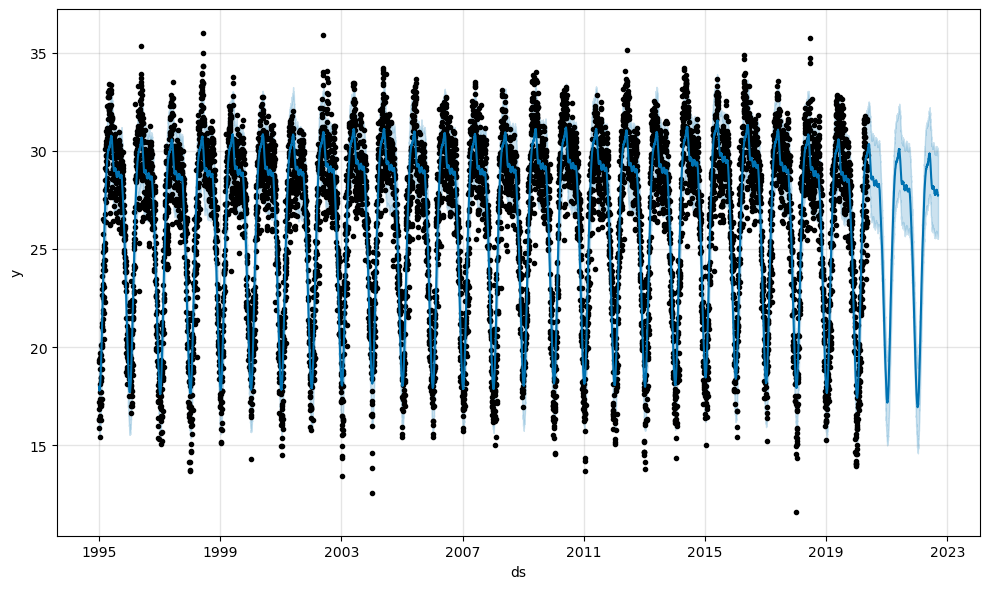

In [24]:
figure1 = model.plot(forecast)

In [25]:
plot_plotly(model, forecast)

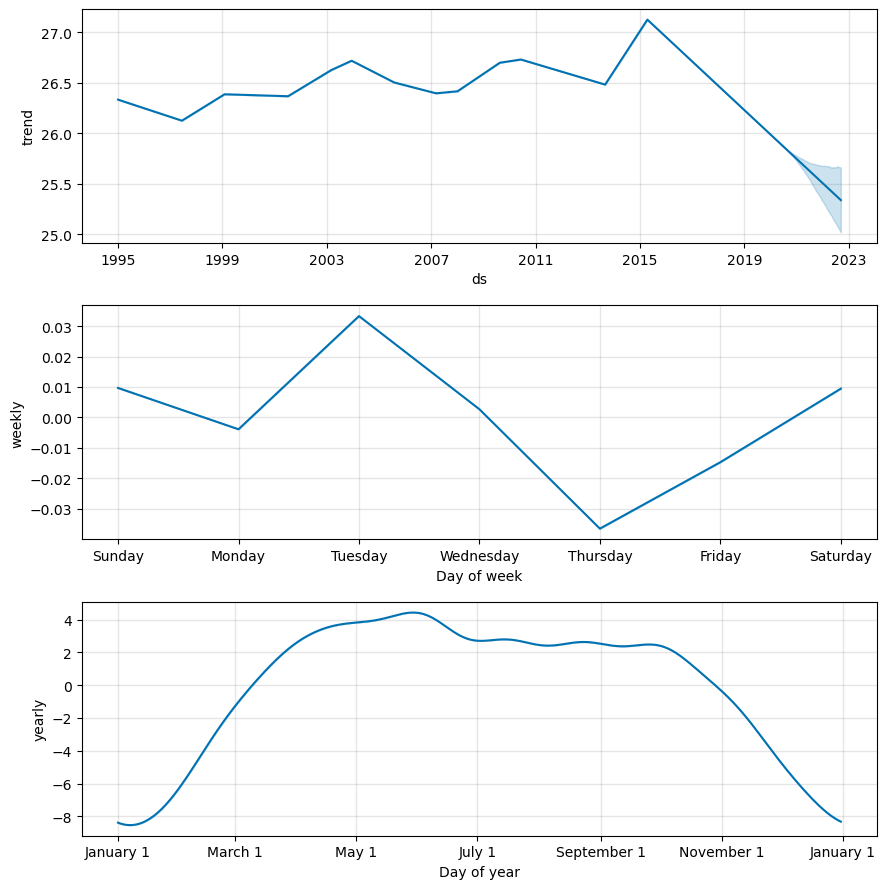

In [26]:
figure2 = model.plot_components(forecast)

In [27]:
plot_components_plotly(model, forecast)

In [28]:
pred.index = pred["ds"].values

In [29]:
pred = pred[pred["ds"] > "2020-05-13"]
pred

ds      trend  yhat_lower  yhat_upper  trend_lower  \
2020-05-14 2020-05-14  25.897509   27.738745   32.164039    25.897509   
2020-05-15 2020-05-15  25.896848   27.758983   32.074999    25.896848   
2020-05-16 2020-05-16  25.896188   27.975405   32.031669    25.896188   
2020-05-17 2020-05-17  25.895527   27.847652   32.262248    25.895527   
2020-05-18 2020-05-18  25.894867   27.944808   32.302942    25.894867   
...               ...        ...         ...         ...          ...   
2022-09-06 2022-09-06  25.339353   25.702608   29.950629    25.024232   
2022-09-07 2022-09-07  25.338693   25.534913   29.859614    25.022886   
2022-09-08 2022-09-08  25.338032   25.513220   29.739926    25.021540   
2022-09-09 2022-09-09  25.337372   25.607854   29.959339    25.020194   
2022-09-10 2022-09-10  25.336711   25.619702   29.825708    25.018847   

            trend_upper  additive_terms  additive_terms_lower  \
2020-05-14    25.897509        4.014502              4.014502   
2020-05-15    25.896848        4.065377              4.065377   
2020-05-16    25.896188        4.120023              4.120023   
2020-05-17    25.895527        4.151905              4.151905   
2020-05-18    25.894867        4.170767              4.170767   
...                 ...             ...                   ...   
2022-09-06    25.661004        2.466042              2.466042   
2022-09-07    25.660885        2.418848              2.418848   
2022-09-08    25.660765        2.365289              2.365289   
2022-09-09    25.660646        2.375311              2.375311   
2022-09-10    25.660526        2.390488              2.390488   

            additive_terms_upper    weekly  weekly_lower  weekly_upper  \
2020-05-14              4.014502 -0.036510     -0.036510     -0.036510   
2020-05-15              4.065377 -0.014697     -0.014697     -0.014697   
2020-05-16              4.120023  0.009447      0.009447      0.009447   
2020-05-17              4.151905  0.009682      0.009682      0.009682   
2020-05-18              4.170767 -0.003884     -0.003884     -0.003884   
...                          ...       ...           ...           ...   
2022-09-06              2.466042  0.033276      0.033276      0.033276   
2022-09-07              2.418848  0.002686      0.002686      0.002686   
2022-09-08              2.365289 -0.036510     -0.036510     -0.036510   
2022-09-09              2.375311 -0.014697     -0.014697     -0.014697   
2022-09-10              2.390488  0.009447      0.009447      0.009447   

              yearly  yearly_lower  yearly_upper  multiplicative_terms  \
2020-05-14  4.051012      4.051012      4.051012                   0.0   
2020-05-15  4.080074      4.080074      4.080074                   0.0   
2020-05-16  4.110576      4.110576      4.110576                   0.0   
2020-05-17  4.142223      4.142223      4.142223                   0.0   
2020-05-18  4.174651      4.174651      4.174651                   0.0   
...              ...           ...           ...                   ...   
2022-09-06  2.432765      2.432765      2.432765                   0.0   
2022-09-07  2.416162      2.416162      2.416162                   0.0   
2022-09-08  2.401799      2.401799      2.401799                   0.0   
2022-09-09  2.390008      2.390008      2.390008                   0.0   
2022-09-10  2.381041      2.381041      2.381041                   0.0   

            multiplicative_terms_lower  multiplicative_terms_upper       yhat  
2020-05-14                         0.0                         0.0  29.912011  
2020-05-15                         0.0                         0.0  29.962226  
2020-05-16                         0.0                         0.0  30.016211  
2020-05-17                         0.0                         0.0  30.047432  
2020-05-18                         0.0                         0.0  30.065634  
...                                ...                         ...        ...  
2022-09-06             

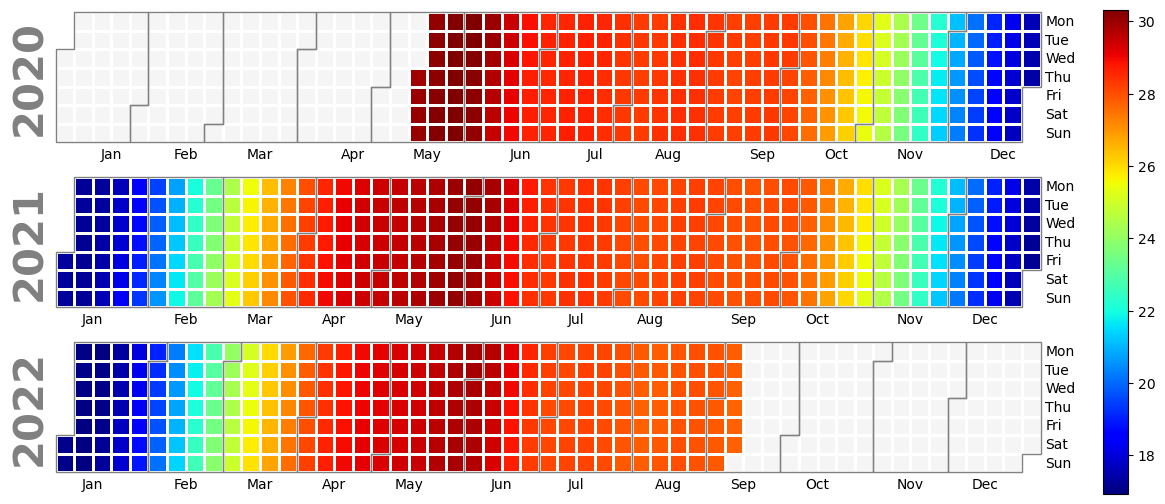

In [30]:
fig2 = calplot.calplot(pred["yhat"], how = "mean", cmap='jet')

# Performnce Measurement of the Model

<p style="font-family:arial; font-weight:bold; letter-spacing: 2px; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid green">

In [31]:
df_cv = cross_validation(model, initial='1095 days', period='180 days', horizon = '365 days')

  0%|          | 0/44 [00:00<?, ?it/s]

09:21:07 - cmdstanpy - INFO - Chain [1] start processing
09:21:07 - cmdstanpy - INFO - Chain [1] done processing
09:21:08 - cmdstanpy - INFO - Chain [1] start processing
09:21:08 - cmdstanpy - INFO - Chain [1] done processing
09:21:09 - cmdstanpy - INFO - Chain [1] start processing
09:21:09 - cmdstanpy - INFO - Chain [1] done processing
09:21:10 - cmdstanpy - INFO - Chain [1] start processing
09:21:10 - cmdstanpy - INFO - Chain [1] done processing
09:21:11 - cmdstanpy - INFO - Chain [1] start processing
09:21:11 - cmdstanpy - INFO - Chain [1] done processing
09:21:12 - cmdstanpy - INFO - Chain [1] start processing
09:21:12 - cmdstanpy - INFO - Chain [1] done processing
09:21:13 - cmdstanpy - INFO - Chain [1] start processing
09:21:14 - cmdstanpy - INFO - Chain [1] done processing
09:21:14 - cmdstanpy - INFO - Chain [1] start processing
09:21:15 - cmdstanpy - INFO - Chain [1] done processing
09:21:15 - cmdstanpy - INFO - Chain [1] start processing
09:21:16 - cmdstanpy - INFO - Chain [1]

In [32]:
df_cv

ds       yhat  yhat_lower  yhat_upper          y     cutoff
0     1998-03-06  25.964632   23.878258   28.092899  26.500000 1998-03-05
1     1998-03-07  26.126609   24.135052   28.202579  23.888889 1998-03-05
2     1998-03-08  26.275961   24.193901   28.344121  21.277778 1998-03-05
3     1998-03-09  26.646070   24.621272   28.576236  23.333333 1998-03-05
4     1998-03-10  26.964654   24.840607   28.990377  25.333333 1998-03-05
...          ...        ...         ...         ...        ...        ...
15986 2020-05-09  30.436520   28.323585   32.707947  31.611111 2019-05-14
15987 2020-05-10  30.438735   28.488075   32.613294  29.166667 2019-05-14
15988 2020-05-11  30.433935   28.331651   32.712224  29.222222 2019-05-14
15989 2020-05-12  30.495855   28.329981   32.625579  31.500000 2019-05-14
15990 2020-05-13  30.486850   28.312680   32.577237  29.777778 2019-05-14

[15991 rows x 6 columns]

In [33]:
df_p = performance_metrics(df_cv)
df_p.head()

horizon       mse      rmse       mae      mape     mdape     smape  \
0 37 days  3.377463  1.837788  1.424967  0.060219  0.043335  0.059502   
1 38 days  3.362937  1.833831  1.419672  0.059898  0.043335  0.059198   
2 39 days  3.341917  1.828091  1.414800  0.059567  0.042948  0.058914   
3 40 days  3.305482  1.818099  1.407282  0.059202  0.042527  0.058557   
4 41 days  3.280431  1.811196  1.399724  0.058882  0.042124  0.058227   

   coverage  
0  0.769970  
1  0.770660  
2  0.772125  
3  0.775746  
4  0.777797

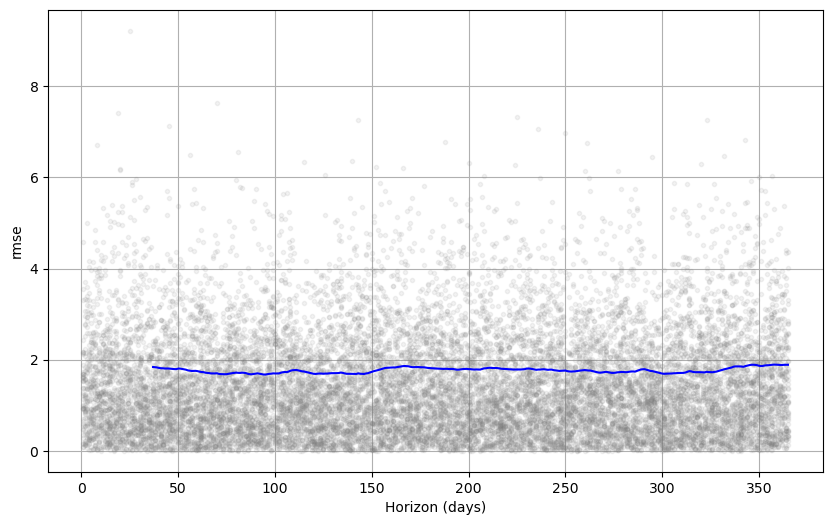

In [34]:
figure3 = plot_cross_validation_metric(df_cv, metric='rmse')

# Saving the Model

<p style="font-family:arial; font-weight:bold; letter-spacing: 2px; font-size:140%; text-align:left;padding: 0px; border-bottom: 3px solid green">

In [35]:
with open('Weather_Kolkata_Prophet_Model.json', 'w') as fout:
    fout.write(model_to_json(model))  # Save model

#with open('Weather_Kolkata_Prophet_Model.json', 'r') as fin:
    #model = model_from_json(fin.read())  # Load model